In [1]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import UpSampling2D
# from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
import cv2 as cv
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
import cv2

In [2]:
optim = tf.keras.optimizers.Adam(0.0002)
class Customloss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
    self.mse = tf.keras.losses.MeanSquaredError()
  def call(self,y_true, y_pred):
    lmse=self.mse(y_true, y_pred)
    # y_true=tf.image.convert_image_dtype(y_true, dtype=tf.int8)
    # y_pred=tf.image.convert_image_dtype(y_pred, dtype=tf.int8)
    ssim =tf.image.ssim(y_true,y_pred, max_val=1, filter_size=13,filter_sigma=1.5, k1=0.02, k2=0.03)
    return lmse+(1-ssim)

In [3]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self,  filters=16, stride=1):
        super().__init__()
        self.F1= filters
        self.stride = stride
        self.conv1= tf.keras.layers.Conv2D(self.F1, (3,3), padding='same',strides=self.stride,kernel_initializer=glorot_uniform(seed=0))
        self.conv2= tf.keras.layers.Conv2D(self.F1, (3,3), padding='same',strides=self.stride,kernel_initializer=glorot_uniform(seed=0))
        self.conv3= tf.keras.layers.Conv2D(self.F1, (3,3), padding='same',strides=self.stride,kernel_initializer=glorot_uniform(seed=0))
    def get_config(self):
        cfg = super().get_config()
        return cfg 
    def call(self, input_tensor):
        # write the architecutre that was mentioned above
        x= self.conv1(input_tensor)
        x_one= tf.nn.relu(x)
        x = self.conv2(x_one)
        x_two= tf.nn.relu(x)
        x = self.conv3(x_two)
        x_three= tf.nn.relu(x)
        x = tf.concat([x_one,x_two,x_three],axis=-1)
        return x

In [4]:
# im1 = tf.image.decode_image(tf.io.read_file('10004.jpg'))
# im1 = tf.image.convert_image_dtype(im1, tf.float32)
# im1 = tf.expand_dims(im1, axis=0)
# print(im1.shape)
im1 = Input(shape=(720,1280,3))
conv    = convolutional_block(16,1)(im1)
concat1 = tf.concat([im1,conv],axis=-1)
conv2   = convolutional_block(16,1)(concat1)
concat2 = tf.concat([im1,conv2,concat1],axis=-1)
conv3   = convolutional_block(16,1)(concat2)
concat3 = tf.concat([im1,conv3,concat2],axis=-1)
conv2D  = Conv2D(3, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0))(concat3)
output  = tf.add(conv2D,im1)

In [5]:
model = Model(inputs = im1, outputs = output)
model.compile(optim, loss=Customloss())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 720, 1280,   0           []                               
                                3)]                                                               
                                                                                                  
 convolutional_block (convoluti  (None, 720, 1280, 4  5088       ['input_1[0][0]']                
 onal_block)                    8)                                                                
                                                                                                  
 tf.concat (TFOpLambda)         (None, 720, 1280, 5  0           ['input_1[0][0]',                
                                1)                                'convolutional_block[0][0]']

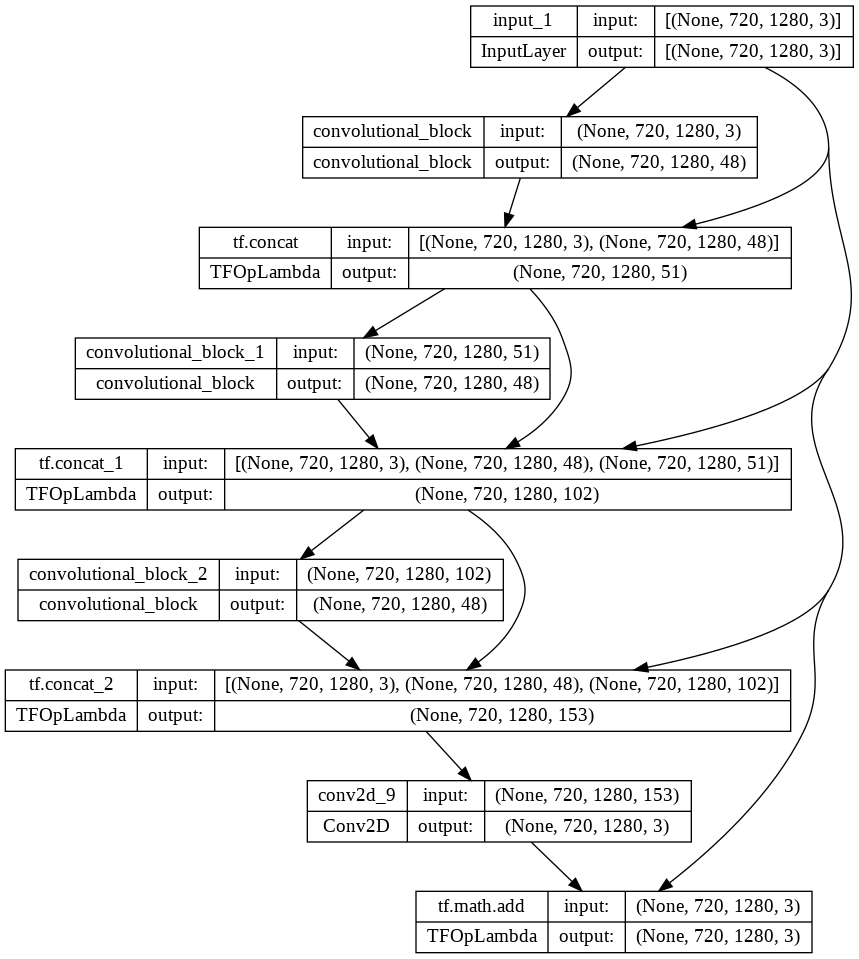

In [6]:
tf.keras.utils.plot_model(model, to_file='model4.png', show_shapes=True, show_layer_names=True,rankdir='TB')

In [21]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    filenames_img=[]
    filenames_mask=[]
    files=os.listdir(root_dir)
    for i in files:
      if i=='raw-890':
        path1=root_dir+'/'+i
      elif i=='reference-890':
        path2=root_dir+'/'+i
    for i in sorted(os.listdir(path1)):
        filenames_img.append(path1+'/'+str(i))
    for i in sorted(os.listdir(path2)):
        filenames_mask.append(path2+'/'+str(i))
    data_df=pd.DataFrame(list(zip(filenames_img, filenames_mask)),
              columns=['image','enhanced_image'])
    return data_df

In [13]:
! wget --header="Host: doc-08-20-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Cookie: AUTH_6sace10vrltvc8q8mdeg53lmsdm5o5ub=05681441820365709611|1668434925000|63vp6vq9q9kbdm41h3t2ss311ch5hlj0; AUTH_6sace10vrltvc8q8mdeg53lmsdm5o5ub_nonce=0i6vblqlo7652" --header="Connection: keep-alive" "https://doc-08-20-docs.googleusercontent.com/docs/securesc/5ld7rcj3hq5fc0qltr7hb18c7vvtn2ps/fp1nae9ip3gjqcbt0veheoku7ns8n7t2/1668435225000/05681441820365709611/05681441820365709611/15Nee-ETnHBnCRk1qwn_mUnYFuACyS-vr?e=download&ax=AEKYgySwns7kHMXT9pmvgs_IMGbntnYEwgK_g_UzJXU_eONT_Bgfppau4BPyEa81nojGOTM1WgH50ZE7glk_bkPxdNeFriYmZZbBLGB3LafPD1Y8iX0zFb6NJh4rBNBgMe5XWGfinqDHaXpuOxgv5vbiH5kLco7BXfyBq2bIISu27mit3XQfdOgN3WHTkFaQ1TuWwgCSgLQU5qUKSOMsAalhXNkBiUmHSRf8ZmoxdA5fvmmTZj-aQ99tG2Ed0QHkA1D4BFZEOEbfdi8CdTl1DpuYUwN_nAZIwlWU22rCDUeYKjKI-K4vLcbnKYOx4MLOrnaQ4Gn57X70ne_54avdVagC2VnYcaEz4b2DYgC3t7CFu1LGrPL1WU3Bhi71VVdGSjVxDogl5cix-yjLT0Kb2dMuaWsj5pnE3RzQI4nU-_vFI1uwe5cj-g_D81OmS7B_wqZZ4WvFMSzRGy52YbzM7VvMBnuyOjYejAOnfT5bGPOdERc5vtTWZAlTSlMF9SpuHVWTSVn8gaCM2TqE-VDcph8wsDxs03YdEdDmQ4-OsHGDUCzt2NA3s6-kyvJEcTruNwVHcL3tumQFLA-AgSu-X3vFGhYs4W4Nb5t6nyJQXA5lXIgjPphy3y2AcAnETWbBOs5AVmOBhiegdrJxmQlFvByhGW5D58a3EeAaxUus9upAXZLInFGj1Nc2lcb0-FA8Msut1jpKnY0F4h41UsT0K1hTqADjd1-yG1WvjlpX67-7K_-ffOfZsBl_BefVs0g0ILaaR-Ah7gOdpZcVAz12tgcZR4Q4N0dmkHVVwFbML-3i48HES4lJMdn0-29r1C2KeDsYM5F5D24a2oJQqJ8sZO_aZjB6neCAv11_I4d7V3w6uA93R-RS-K12jilg89WdpITaUs7OMs_5HZVOFqI20Afk-rSZb6hhlA6mShB41ptHr3dLlJM5WjuKQYL8tBGO39qpW7bV_joXsA&uuid=a72d6c4b-a6b4-42d2-962f-0f9a410303f1&authuser=0&nonce=0i6vblqlo7652&user=05681441820365709611&hash=i7pv15bldvlf5qpph25csifl63co43v6" -c -O 'raw-890.zip'

--2022-11-14 14:14:39--  https://doc-08-20-docs.googleusercontent.com/docs/securesc/5ld7rcj3hq5fc0qltr7hb18c7vvtn2ps/fp1nae9ip3gjqcbt0veheoku7ns8n7t2/1668435225000/05681441820365709611/05681441820365709611/15Nee-ETnHBnCRk1qwn_mUnYFuACyS-vr?e=download&ax=AEKYgySwns7kHMXT9pmvgs_IMGbntnYEwgK_g_UzJXU_eONT_Bgfppau4BPyEa81nojGOTM1WgH50ZE7glk_bkPxdNeFriYmZZbBLGB3LafPD1Y8iX0zFb6NJh4rBNBgMe5XWGfinqDHaXpuOxgv5vbiH5kLco7BXfyBq2bIISu27mit3XQfdOgN3WHTkFaQ1TuWwgCSgLQU5qUKSOMsAalhXNkBiUmHSRf8ZmoxdA5fvmmTZj-aQ99tG2Ed0QHkA1D4BFZEOEbfdi8CdTl1DpuYUwN_nAZIwlWU22rCDUeYKjKI-K4vLcbnKYOx4MLOrnaQ4Gn57X70ne_54avdVagC2VnYcaEz4b2DYgC3t7CFu1LGrPL1WU3Bhi71VVdGSjVxDogl5cix-yjLT0Kb2dMuaWsj5pnE3RzQI4nU-_vFI1uwe5cj-g_D81OmS7B_wqZZ4WvFMSzRGy52YbzM7VvMBnuyOjYejAOnfT5bGPOdERc5vtTWZAlTSlMF9SpuHVWTSVn8gaCM2TqE-VDcph8wsDxs03YdEdDmQ4-OsHGDUCzt2NA3s6-kyvJEcTruNwVHcL3tumQFLA-AgSu-X3vFGhYs4W4Nb5t6nyJQXA5lXIgjPphy3y2AcAnETWbBOs5AVmOBhiegdrJxmQlFvByhGW5D58a3EeAaxUus9upAXZLInFGj1Nc2lcb0-FA8Msut1jpKnY0F4h41UsT0K1hTqADjd1-yG1WvjlpX67

## Download dataset raw.zip and reference.zip from drive and unzip them

In [22]:
data_df=return_file_names_df('/content')
data_df.head()

,image,enhanced_image
0,/content/raw-890/100_img_.png,/content/reference-890/100_img_.png
1,/content/raw-890/10139.png,/content/reference-890/10139.png
2,/content/raw-890/10151.png,/content/reference-890/10151.png
3,/content/raw-890/101_img_.png,/content/reference-890/101_img_.png
4,/content/raw-890/102_img_.png,/content/reference-890/102_img_.png


In [23]:
class Dataset:
  def __init__(self, data_df1):
        self.data = data_df1
        # the paths of images
        self.images_fps   = list(self.data['image'].values)
        # the paths of segmentation images
        self.masks_fps    = list(self.data['enhanced_image'].values)

  def __getitem__(self, i):
        # read data
        im_image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        im_enhanced = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        #calculate the 50 percent of original dimensions
        width  = 1280
        height =720

        # dsize
        dsize = (width, height)

        # resize image
        im_image   = cv2.resize(im_image, dsize,interpolation=cv2.INTER_NEAREST)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        im_enhanced = cv2.resize(im_enhanced,dsize,interpolation=cv2.INTER_NEAREST)

        return im_image/255.0,im_enhanced/255.0
        
  def __len__(self):
        return len(self.data)
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [24]:
X_train, X_test = train_test_split(data_df, test_size=0.2)

In [25]:
# Dataset for train images
train_dataset = Dataset(X_train)
test_dataset  = Dataset(X_test)

BATCH_SIZE=1
train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 720, 1280, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 720, 1280, 3)

(1, 720, 1280, 3)


In [26]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=40,validation_data=test_dataloader)

Epoch 1/40
712/712 [==============================] - 79s 95ms/step - loss: 0.1841 - val_loss: 0.1764
Epoch 2/40
712/712 [==============================] - 69s 97ms/step - loss: 0.1702 - val_loss: 0.1625
Epoch 3/40
712/712 [==============================] - 69s 97ms/step - loss: 0.1653 - val_loss: 0.1584
Epoch 4/40
712/712 [==============================] - 69s 97ms/step - loss: 0.1625 - val_loss: 0.1623
Epoch 5/40
712/712 [==============================] - 69s 97ms/step - loss: 0.1602 - val_loss: 0.1556
Epoch 6/40
712/712 [==============================] - 69s 97ms/step - loss: 0.1592 - val_loss: 0.1628
Epoch 7/40
712/712 [==============================] - 69s 97ms/step - loss: 0.1580 - val_loss: 0.1529
Epoch 8/40
712/712 [==============================] - 69s 97ms/step - loss: 0.1569 - val_loss: 0.1596
Epoch 9/40
712/712 [==============================] - 68s 95ms/step - loss: 0.1557 - val_loss: 0.1502
Epoch 10/40
712/712 [==============================] - 68s 96ms/step - loss: 0.154

In [46]:
imm=cv.imread('/content/10004.jpg')
imm.shape

(720, 1280, 3)

In [47]:
new_imm=tf.expand_dims(imm, axis=0)

In [48]:
new_imm.shape

TensorShape([1, 720, 1280, 3])

In [49]:
images=model.predict(new_imm/255)

1/1 [==============================] - 0s 27ms/step


In [50]:
images

array([[[[0.7007675 , 0.53279245, 0.21590951],
         [0.8311289 , 0.70861226, 0.33265594],
         [0.8205163 , 0.7249791 , 0.33028764],
         ...,
         [0.33930734, 0.26189634, 0.15158233],
         [0.33471733, 0.26398805, 0.13770756],
         [0.31610405, 0.26922125, 0.14266501]],

        [[0.6070673 , 0.450005  , 0.23723061],
         [0.6758364 , 0.55022913, 0.2950884 ],
         [0.844208  , 0.72499657, 0.48101425],
         ...,
         [0.30233946, 0.2336251 , 0.14443766],
         [0.3222817 , 0.23529363, 0.1378353 ],
         [0.30164674, 0.254376  , 0.14372292]],

        [[0.5468236 , 0.41395384, 0.19263835],
         [0.5277569 , 0.4049611 , 0.14620197],
         [0.56901443, 0.47148782, 0.21396574],
         ...,
         [0.29513913, 0.24919426, 0.18025789],
         [0.3349428 , 0.26318204, 0.1732282 ],
         [0.3174491 , 0.277562  , 0.1659173 ]],

        ...,

        [[0.29900146, 0.29921496, 0.12141222],
         [0.35425127, 0.2896951 , 0.14674798]

In [53]:
cv.imwrite('uwcnn10004.jpg',images[0]*255)

True

In [ ]:
a=0
b=255
def contrast_stretching(band):
    # to remove effect of outliers
    c=np.percentile(band,5)
    d=np.percentile(band,95)
    normalized_channel=(band-c)*((b-a)/(d-c))+a
    return normalized_channel

In [ ]:
img = cv.imread('10004.jpg')

new_image=np.zeros([img.shape[0],img.shape[1],3])
for i in range(3):
    new_image[:,:,i]=contrast_stretching(img[:,:,i])
# show image input vs output
cv.imwrite('res5.jpg',new_image)

True

In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import skimage.measure

In [2]:
automatic=cv.imread('b2.jpg')
automatic=cv.cvtColor(automatic,cv.COLOR_BGR2RGB)
he_hsv=cv.imread('contrast_stretching.jpg')
he_hsv=cv.cvtColor(he_hsv,cv.COLOR_BGR2RGB)
he_hsv_gf=cv.imread('diff_evolution.jpg')
he_hsv_gf=cv.cvtColor(he_hsv_gf,cv.COLOR_BGR2RGB)
he_yuv=cv.imread('uwcnn10004.jpg')
he_yuv=cv.cvtColor(he_yuv,cv.COLOR_BGR2RGB)

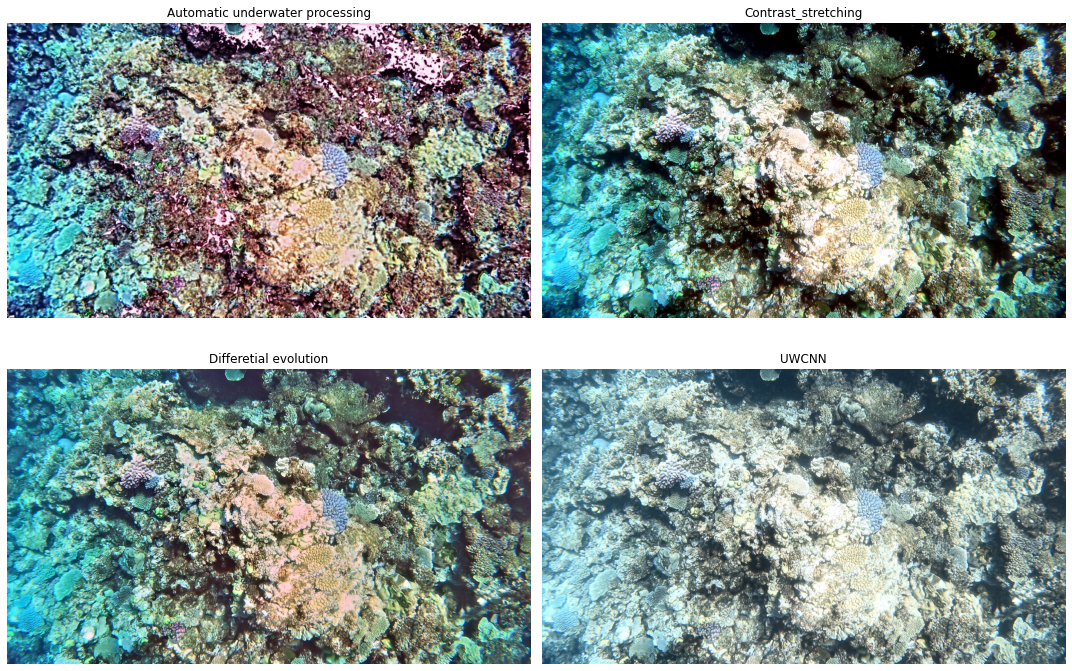

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10),sharex=True, sharey=True)
ax[0][0].imshow(automatic)
ax[0][0].axis('off')
ax[0][0].set_title('Automatic underwater processing')
ax[0][1].imshow(he_hsv)
ax[0][1].axis('off')
ax[0][1].set_title('Contrast_stretching')
ax[1][0].imshow(he_hsv_gf)
ax[1][0].axis('off')
ax[1][0].set_title('Differetial evolution')
ax[1][1].imshow(he_yuv)
ax[1][1].axis('off')
ax[1][1].set_title('UWCNN')
fig.tight_layout()

plt.show()

In [ ]:
img=cv.imread('10004.jpg')
entropy_re = skimage.measure.shannon_entropy(he_yuv)
print('Reconstructed_image_entropy',round(entropy_re,3))
entropy = skimage.measure.shannon_entropy(img)
print('Original_image_entropy',round(entropy,3))
print('With Differential_evolution the underwater image was enhanced with a ratio of {:.3f} %'.format((entropy_re-entropy)/entropy*100))

Reconstructed_image_entropy 7.847
Original_image_entropy 7.903
With Differential_evolution the underwater image was enhanced with a ratio of -0.717 %
